In [19]:
# Imports & Basic Setup
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [20]:
# Load & Organize File Paths

data_path = os.path.join('..', 'datasets', 'GTZAN') 
genres = os.listdir(data_path)

file_paths = []
for genre in genres:
    genre_folder = os.path.join(data_path, genre)
    if not os.path.isdir(genre_folder):
        continue
    for file_name in os.listdir(genre_folder):
        if file_name.endswith('.au'):  
            file_paths.append({
                'file_path': os.path.join(genre_folder, file_name),
                'genre': genre
            })

df = pd.DataFrame(file_paths)
print("DataFrame head:\n", df.head())
print("Total files:", len(df))

DataFrame head:
                                 file_path  genre
0  ..\datasets\GTZAN\blues\blues.00000.au  blues
1  ..\datasets\GTZAN\blues\blues.00001.au  blues
2  ..\datasets\GTZAN\blues\blues.00002.au  blues
3  ..\datasets\GTZAN\blues\blues.00003.au  blues
4  ..\datasets\GTZAN\blues\blues.00004.au  blues
Total files: 1000



Genre distribution:
 genre
blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
reggae       100
rock         100
Name: count, dtype: int64


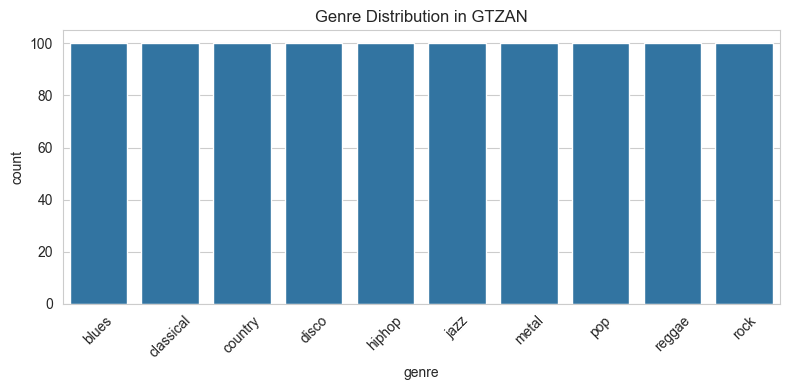

In [21]:
# Data Exploration
if not df.empty:
    genre_counts = df['genre'].value_counts()
    print("\nGenre distribution:\n", genre_counts)
    
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x='genre', order=genre_counts.index)
    plt.title('Genre Distribution in GTZAN')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No files found. Check your dataset path or file extensions.")
    raise SystemExit("Stopping.")

In [22]:
# Feature Extraction (MFCC)

def extract_mfcc(file_path, sr=22050, n_mfcc=13, duration=30):
    
    # Loads an audio file, then computes mean MFCC features. Returns a 1D numpy array of shape (n_mfcc,).
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_mean = np.mean(mfcc, axis=1)
        return mfcc_mean
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

feature_list = []
valid_rows = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting MFCC"):
    file_path = row['file_path']
    genre_label = row['genre']
    
    features = extract_mfcc(file_path)
    if features is not None:
        feature_list.append(features)
        valid_rows.append((file_path, genre_label))

if not feature_list:
    print("No MFCC features were extracted. Check environment or data format.")
    raise SystemExit("Stopping.")

df_features = pd.DataFrame(feature_list)
df_features.columns = [f'mfcc_{i}' for i in range(df_features.shape[1])]
df_features['genre'] = [g for (_, g) in valid_rows]

print("\nHead of df_features:\n", df_features.head())
print("Shape of df_features:", df_features.shape)

Extracting MFCC: 100%|██████████| 1000/1000 [00:34<00:00, 28.62it/s]


Head of df_features:
        mfcc_0      mfcc_1     mfcc_2     mfcc_3     mfcc_4     mfcc_5  \
0 -113.619385  121.553017 -19.151056  42.345768  -6.371168  18.613033   
1 -207.581512  123.997147   8.939115  35.870758   2.919971  21.518787   
2  -90.776344  140.448608 -29.100559  31.687340 -13.975973  25.741686   
3 -199.462006  150.094727   5.649167  26.870144   1.755441  14.236880   
4 -160.291855  126.195770 -35.602501  22.151169 -32.487640  10.862022   

      mfcc_6     mfcc_7     mfcc_8     mfcc_9    mfcc_10   mfcc_11   mfcc_12  \
0 -13.692060  15.339378 -12.283618  10.973775  -8.322410  8.806787 -3.665802   
1  -8.555368  23.355938 -10.101037  11.906445  -5.558123  5.375942 -2.237833   
2 -13.644712  11.623112 -11.775920   9.700466 -13.115349  5.785763 -8.899733   
3  -4.828873   9.297849  -0.753142   8.147393  -3.195236  6.085354 -2.476188   
4 -23.357162   0.500523 -11.804770   1.203878 -13.085074 -2.809849 -6.935621   

   genre  
0  blues  
1  blues  
2  blues  
3  blues  
4 

In [23]:
# Encode & Scale
label_encoder = LabelEncoder()
df_features['genre_encoded'] = label_encoder.fit_transform(df_features['genre'])

X = df_features.drop(columns=['genre', 'genre_encoded'])
y = df_features['genre_encoded']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Train/Test Split
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTrain shape:", X_train.shape, "Validation shape:", X_val.shape)


Train shape: (800, 13) Validation shape: (200, 13)



=== Random Forest Results ===
              precision    recall  f1-score   support

       blues       0.64      0.70      0.67        20
   classical       0.76      0.95      0.84        20
     country       0.70      0.35      0.47        20
       disco       0.37      0.35      0.36        20
      hiphop       0.61      0.55      0.58        20
        jazz       0.62      0.75      0.68        20
       metal       0.67      0.70      0.68        20
         pop       0.65      0.75      0.70        20
      reggae       0.58      0.55      0.56        20
        rock       0.47      0.45      0.46        20

    accuracy                           0.61       200
   macro avg       0.61      0.61      0.60       200
weighted avg       0.61      0.61      0.60       200



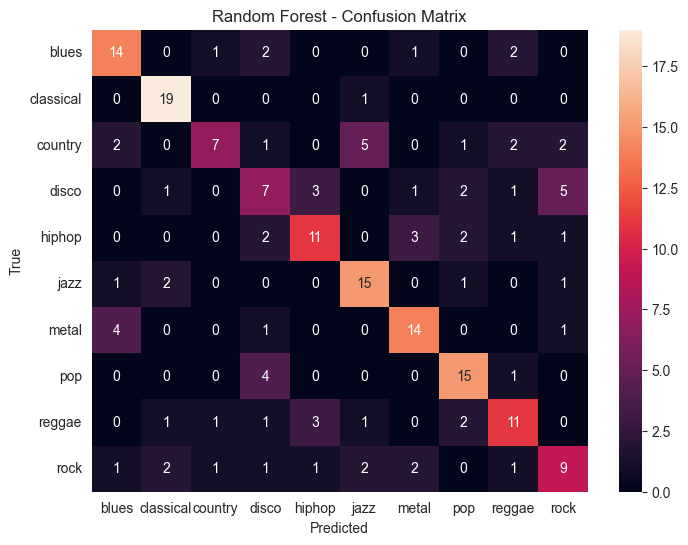

In [24]:
# Baseline Models

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)

print("\n=== Random Forest Results ===")
print(classification_report(y_val, y_pred_rf, target_names=label_encoder.classes_))

cm_rf = confusion_matrix(y_val, y_pred_rf)
plt.figure(figsize=(8,6))
sns.heatmap(cm_rf, annot=True, fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


=== SVM (Linear Kernel) Results ===
              precision    recall  f1-score   support

       blues       0.46      0.65      0.54        20
   classical       0.87      1.00      0.93        20
     country       0.43      0.30      0.35        20
       disco       0.35      0.35      0.35        20
      hiphop       0.46      0.60      0.52        20
        jazz       0.57      0.60      0.59        20
       metal       0.74      0.70      0.72        20
         pop       0.60      0.75      0.67        20
      reggae       0.44      0.40      0.42        20
        rock       0.33      0.10      0.15        20

    accuracy                           0.55       200
   macro avg       0.53      0.54      0.52       200
weighted avg       0.53      0.55      0.52       200



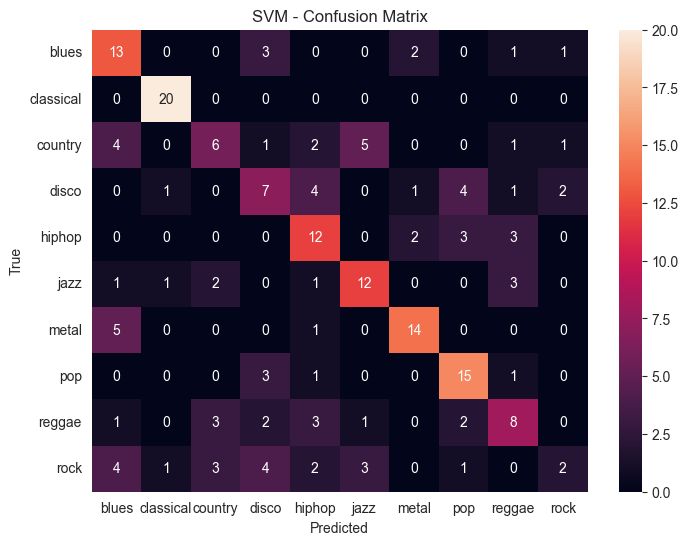


----- Baseline Modeling Complete! ----


In [25]:
# SVM
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_val)

print("\n=== SVM (Linear Kernel) Results ===")
print(classification_report(y_val, y_pred_svm, target_names=label_encoder.classes_))

cm_svm = confusion_matrix(y_val, y_pred_svm)
plt.figure(figsize=(8,6))
sns.heatmap(cm_svm, annot=True, fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("SVM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\n----- Baseline Modeling Complete! ----")